In this kernel I want to build a simple EDA (exploratory data analysis) pipeline that can be applied to any datasets with only some slight tweaks neccessary. At the moment, this is based on a continuous **target** variable, i.e. for regression. I will add a pipeline for **categorical** target variables soon.

# Read in the Libraries and Dataset

In [1]:
# Import the modules

import pandas as pd
import numpy as np
import sklearn as sk

# Data Vis
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')

In [2]:
# Get the data
train = pd.read_csv('train.csv')

# Change the settings so that you can see all columns of the dataframe when calling df.head()
pd.set_option('display.max_columns',999)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Types

Below you can see the types of data in the dataset. Pandas usually does a good job at assigning the correct data type but sometimes it doesn't. If that's the case you can change the datatype.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Convert data to object
#object_train = []
#train[object_train] = train[object_train].astype('object')

# Convert data to numeric
#numeric_train = train.select_dtypes(include=[np.number]).columns.tolist()
#train[numeric_train] = train[numeric_train].astype('float64')

# Missing Data

Not only can the data type be incorrect but there could also be missing data. Let's have a look at this visually.

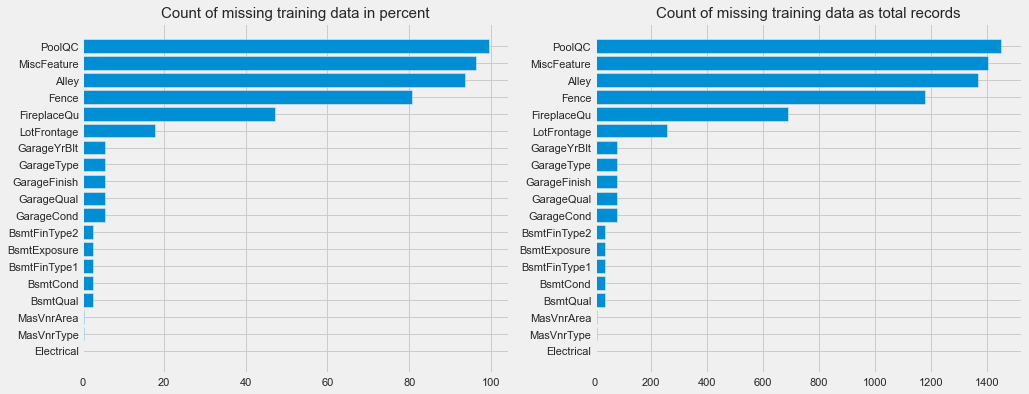

In [5]:
# Capture the necessary data
variables = train.columns

count = []

for variable in variables:
    length = train[variable].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(train), 2)
count = pd.Series(count)

missing = pd.DataFrame()
missing['variables'] = variables
missing['count'] = len(train) - count
missing['count_pct'] = 100 - count_pct
missing = missing[missing['count_pct'] > 0]
missing.sort_values(by=['count_pct'], inplace=True)
missing_train = np.array(missing['variables'])

#Plot number of available data per variable
plt.subplots(figsize=(15,6))

# Plots missing data in percentage
plt.subplot(1,2,1)
plt.barh(missing['variables'], missing['count_pct'])
plt.title('Count of missing training data in percent', fontsize=15)

# Plots total row number of missing data
plt.subplot(1,2,2)
plt.barh(missing['variables'], missing['count'])
plt.title('Count of missing training data as total records', fontsize=15)

plt.show()

# Target is Continuous

## Get the Features and Target

In [6]:
# Get target
target = 'SalePrice'

# Get quantitative features and delete the unnccessary features
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')

# Get categorical features
categorical = [f for f in train.columns if train.dtypes[f] == 'object']


## Histogram of Target

Let's first look at the target variable. Because it is continuous/numeric a histogram is a good choice.

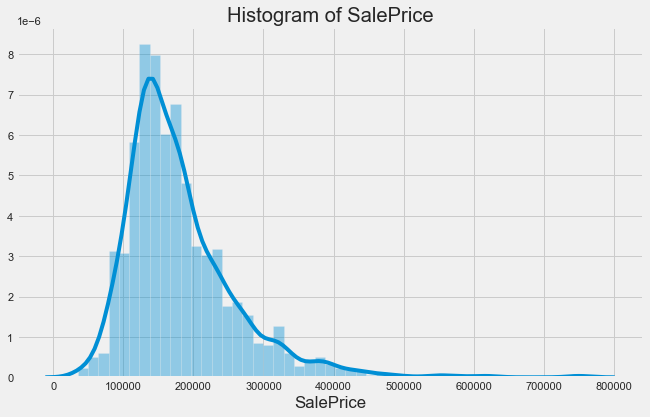

In [7]:
plt.figure(figsize=(10,6))
sns.distplot(train[target])
plt.title('Histogram of %s' % target)
plt.show()

## Quantitative Features

Next up are the quantitative featuires. I have plotted histograms and scatterplots against the target variable. This gives you an idea how the features are distributed and how they interact with the target variable. Skewed histograms may inidcate that you have to log-transform thet particular feature.

**Histograms of Quantitative Features**

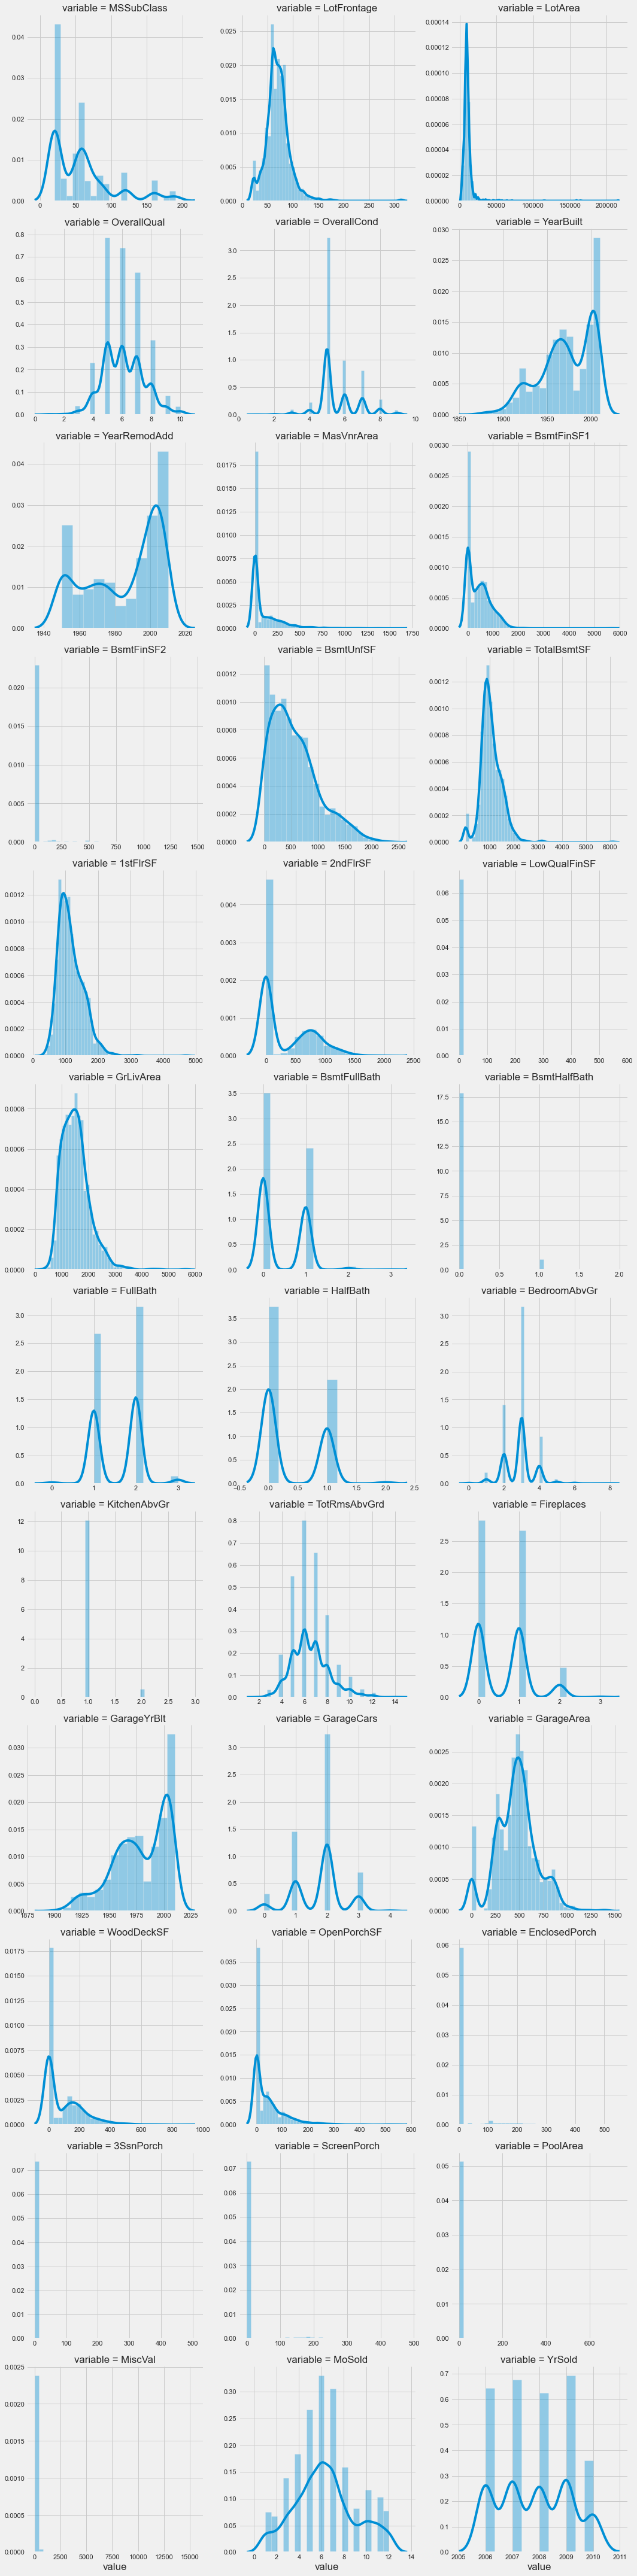

In [8]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(sns.distplot, "value")

**Scatterplot of Quantitative Features against Target**

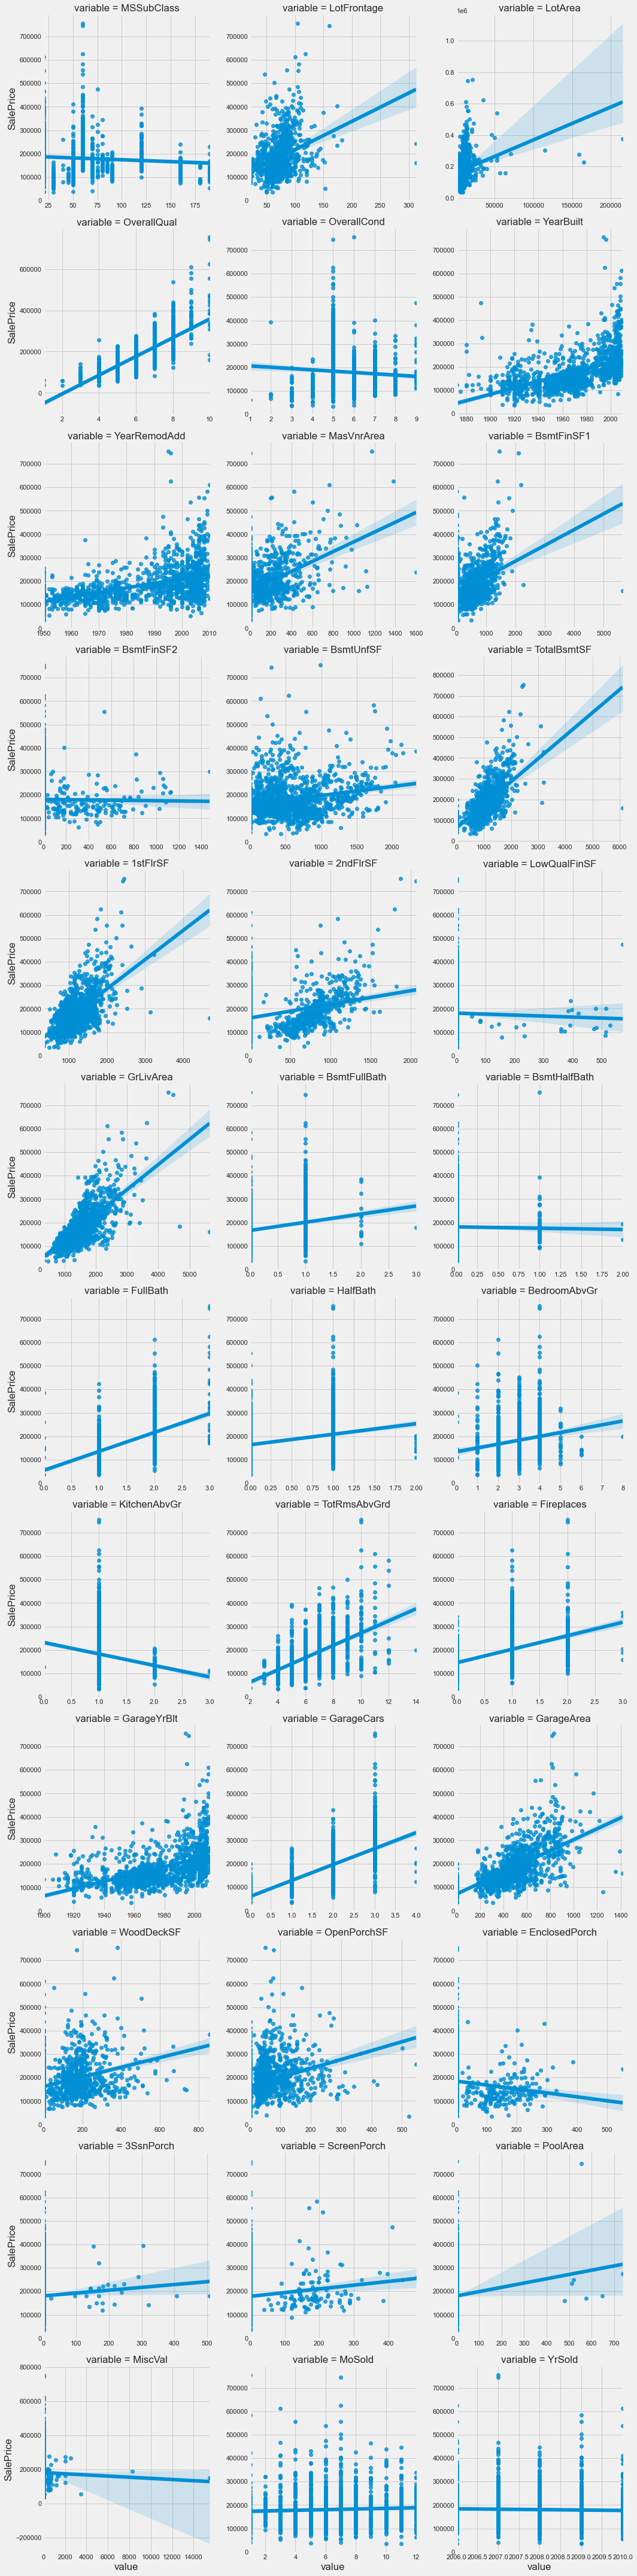

In [9]:
f = pd.melt(train, id_vars=[target], value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(sns.regplot, "value", target)

## Categorical Features

Histograms and scatterplots don't work for categorical features. Instead I use countplots and box-whisker plots that try to get at the same thing. You get an idea of how a feature is distributed - are the categories within a feature balanced or not; do the different categories have different/distinct target values?

**Countplots of Categorical Features**

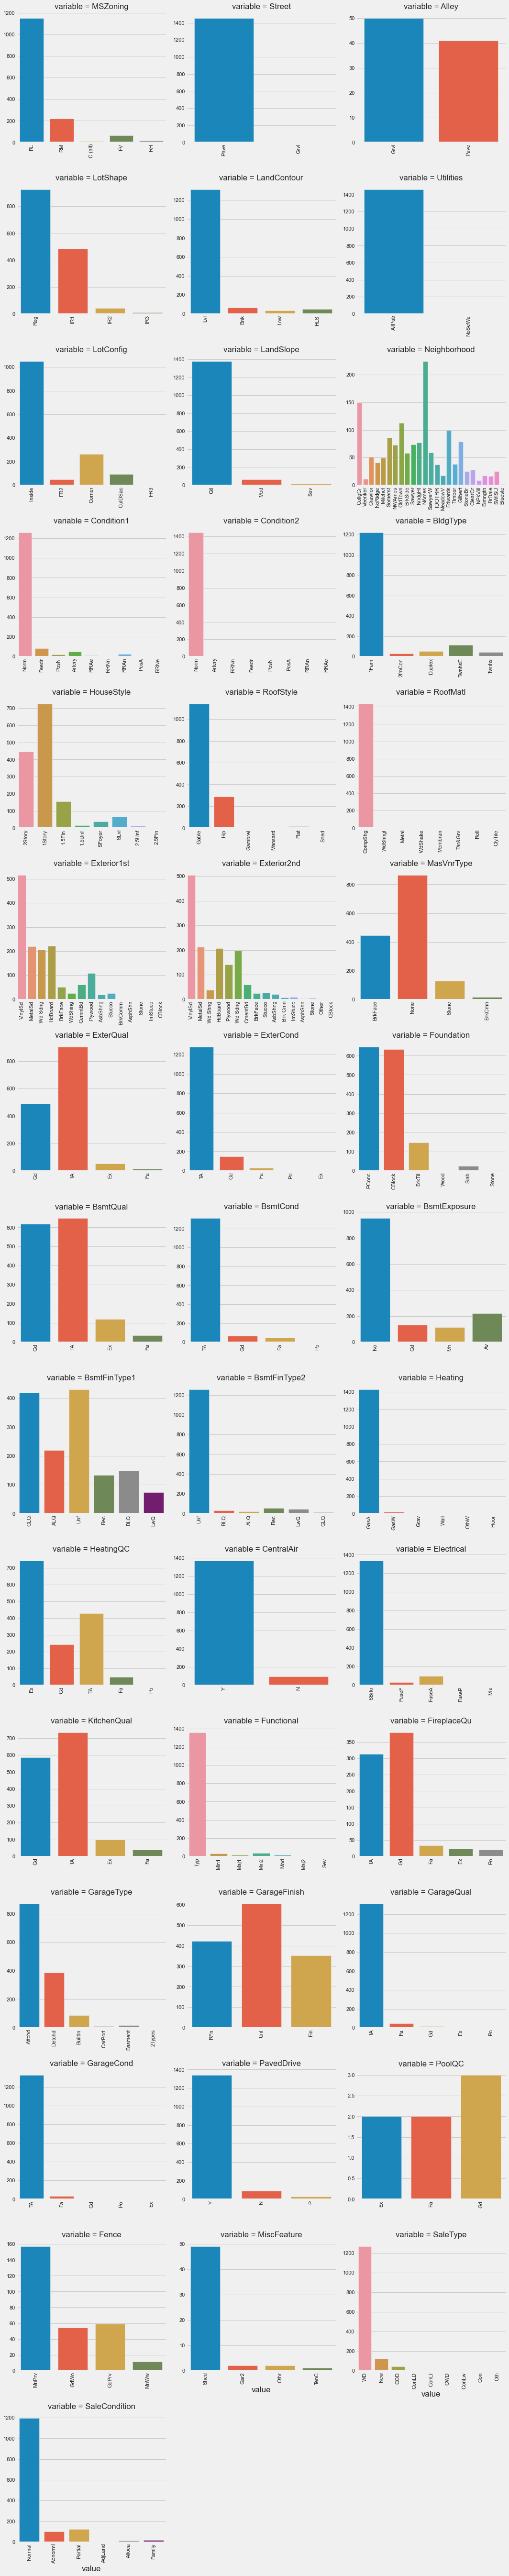

In [10]:
def countplot(x, **kwargs):
    sns.countplot(x=x)
    x=plt.xticks(rotation=90)
f = pd.melt(train, value_vars=categorical)
g = sns.FacetGrid(f, col='variable',  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(countplot, 'value')

**Box-whisker Plots of Categorical Features against Target**

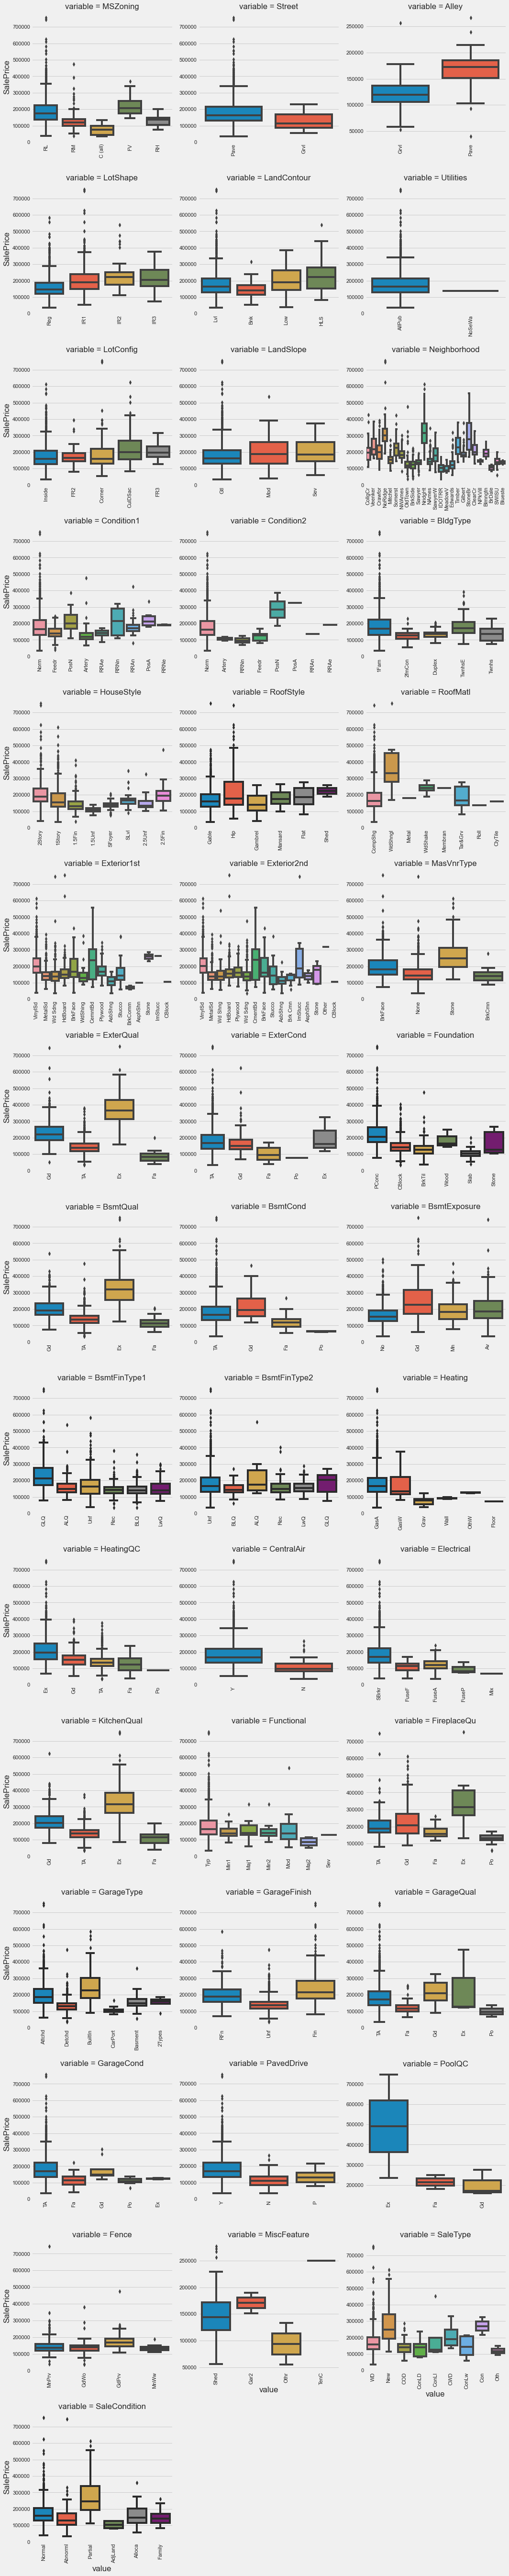

In [11]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=[target], value_vars=categorical)
g = sns.FacetGrid(f, col='variable',  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value', target)

## Correlation Matrix of Numeric Features

We already got an idea of the correlations between the quantitative features and the target from the scatterplots but we also need to check how all features correlated with each other. A correlation matrix is a good choice for that. On thing we can learn from the matrix is whether some features are highly correlated with each, which can affect the coefficients and significance of them if you wanted to look at them. If that is the case, you might to drop one of them or use PCA to reduce the number of features.

In [ ]:
# Correlation Matrix

# Compute the correlation matrix
d= train
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=False, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

Do you have comments or suggestion or maybe you managed to apply the code to a different data set, please let me know.